In [10]:
import sys
sys.path.append("..") 
import numpy as np
from scipy.sparse import diags
import matplotlib.pyplot as plt
import cuqi

# This makes sure modules are reloaded each time a function is called (optional)
%load_ext autoreload
%autoreload 2

# Set rng seed 
np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:

# Load file with forward matrix, data and phantom
ref = np.load("data/Deconvolution.npz")

# Extract parameters
A = ref["A"]                # Matrix (forward model) - Convolution with Gaussian kernel
data = ref["data"]          # Data (noisy)
phantom = ref["phantom"]    # Phantom / ground truth
m,n = A.shape               # Dimensions of problem

# This deconvolution inverse problem looks like:
# b = A*x+e
# where e ~ Gaussian white noise. Suppose we know the standard deviation of noise is 0.05.


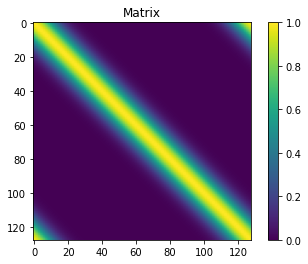

In [12]:
plt.imshow(A); plt.title("Matrix"); plt.colorbar(); plt.show()


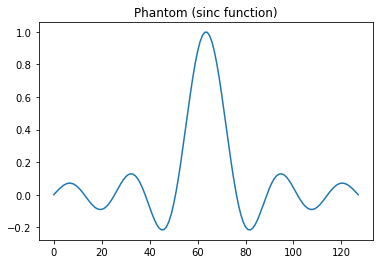

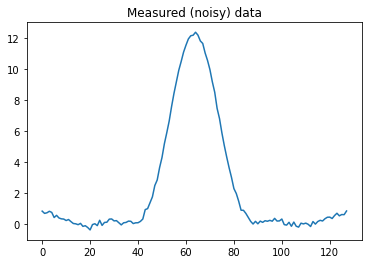

In [13]:
plt.plot(phantom); plt.title("Phantom (sinc function)"); plt.show()
plt.plot(data); plt.title("Measured (noisy) data"); plt.show()


In [14]:

# Define as linear model
model = cuqi.model.LinearModel(A)


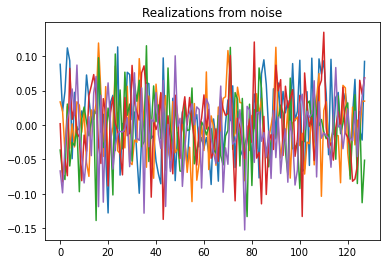

In [15]:

#  Define noise
noise_std = 0.05
noise = cuqi.distribution.Gaussian(np.zeros(m),noise_std,np.eye(m))

plt.plot(noise.sample(5)); plt.title('Realizations from noise'); plt.show()


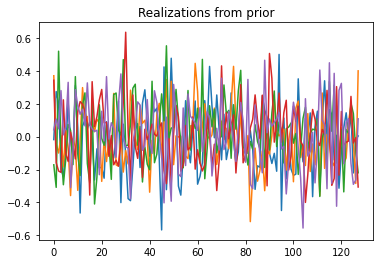

In [16]:
prior_std = 0.2
prior = cuqi.distribution.Gaussian(np.zeros(n),prior_std,np.eye(n))

plt.plot(prior.sample(5)); plt.title('Realizations from prior'); plt.show()


In [17]:

# Type1: data = model(x)+noise
IP = cuqi.problem.Type1(data,model,noise,prior)


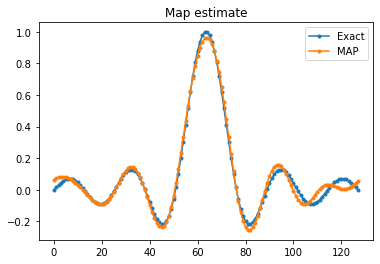

In [18]:
# Depending on defined model, noise and prior a method for estimating map is selected.
x_MAP = IP.MAP() 

# Plot
plt.plot(phantom,'.-')
plt.plot(x_MAP,'.-')
plt.title("Map estimate")
plt.legend(["Exact","MAP"])
plt.show()



 Sample 5000 / 5000
Elapsed time: 0.07499885559082031


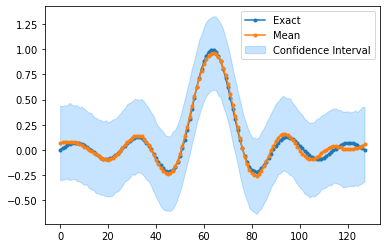

In [19]:
# Number of samples
Ns = 5000

# Sample (depending on defined model, noise and prior a sampler is selected)
result = IP.sample(Ns)

# plot mean + 95% of samples
result.plot_ci(95,exact=phantom)


In [20]:

result.diagnostics()


Geweke test passed at indices  (array([  4,  14,  18,  19,  28,  29,  30,  35,  36,  37,  45,  46,  47,
        48,  49,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  77,  78,  80,
        81,  83,  86,  91,  92,  94,  95,  96,  98, 105, 106, 110, 112,
       127], dtype=int64),) 

Geweke test NOT passed at indices  (array([  0,   1,   2,   3,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        15,  16,  17,  20,  21,  22,  23,  24,  25,  26,  27,  31,  32,
        33,  34,  38,  39,  40,  41,  42,  43,  44,  50,  51,  52,  74,
        75,  76,  79,  82,  84,  85,  87,  88,  89,  90,  93,  97,  99,
       100, 101, 102, 103, 104, 107, 108, 109, 111, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126], dtype=int64),) 



..\cuqi\diagnostics.py:86: RuntimeWarning: divide by zero encountered in true_divide
  f = 1/(n*idx2)


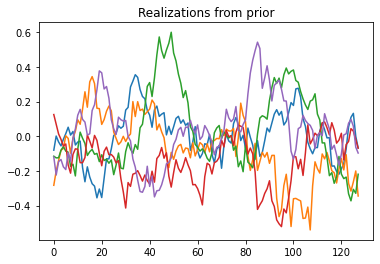

In [21]:

# Define correlation matrix where 30 closest neighbours are correlated
l = 30
corr = np.linspace(0,1,int(l/2)+1); corr = np.hstack((corr,np.flipud(corr[:-1])))
indexes = np.linspace(-l/2,l/2,l+1,dtype=int)
corrmat = diags(corr, indexes, shape=(n, n)).toarray()

# Set new prior
IP.prior = cuqi.distribution.Gaussian(np.zeros(n),prior_std,corrmat)

plt.plot(IP.prior.sample(5)); plt.title('Realizations from prior'); plt.show()



 Sample 5000 / 5000
Elapsed time: 0.07499909400939941


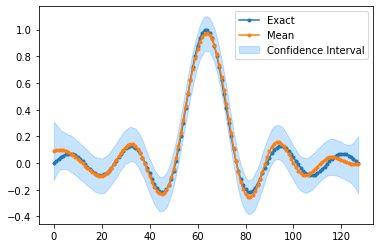

In [22]:
result = IP.sample(Ns)

# plot mean + 95% of samples
result.plot_ci(95,exact=phantom)


In [23]:

tp = cuqi.testproblem.Deconvolution() #Default values


In [24]:
# Parameters for Deconvolution problem
dim = 128
kernel = ["Gauss","Sinc","vonMises"]
phantom = ["Gauss","Sinc","vonMises","Square","Hat","Bumps","DerivGauss"]
noise_type = ["Gaussian","xxxGaussian"]
noise_std = 0.05

# Test problem
tp = cuqi.testproblem.Deconvolution(
    dim = dim,
    kernel=kernel[0],
    phantom=phantom[3],
    noise_type=noise_type[0],
    noise_std = noise_std
)


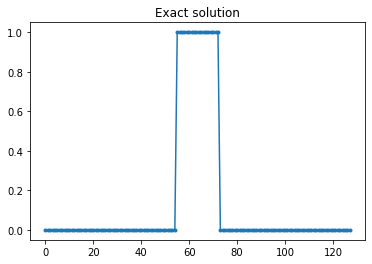

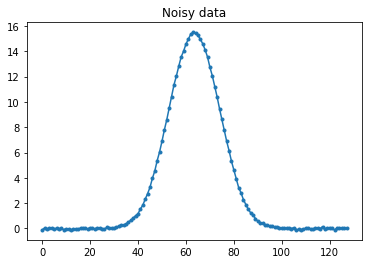

In [25]:
plt.plot(tp.exactSolution,'.-'); plt.title("Exact solution"); plt.show()

# Plot data
plt.plot(tp.data,'.-'); plt.title("Noisy data"); plt.show()



 Sample 5000 / 5000
Elapsed time: 0.07699847221374512


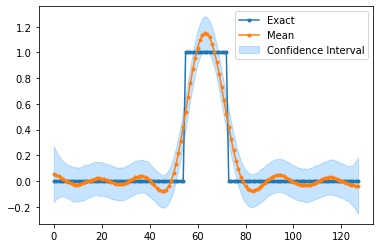

In [26]:

tp.prior = cuqi.distribution.Gaussian(np.zeros(n),prior_std,corrmat)

# Sample
result = tp.sample(Ns)

# plot mean + 95% of samples
result.plot_ci(95,exact=tp.exactSolution)


..\cuqi\sampler.py:190: RuntimeWarning: overflow encountered in exp
  ratio = np.exp(target_eval_star - target_eval_t)  # proposal is symmetric


Burn-in 0 / 1000
Burn-in 500 / 1000
Burn-in 1000 / 1000
Sample 500 / 5000
Sample 1000 / 5000
Sample 1500 / 5000
Sample 2000 / 5000
Sample 2500 / 5000
Sample 3000 / 5000
Sample 3500 / 5000
Sample 4000 / 5000
Sample 4500 / 5000

Average acceptance rate all components: 0.2321328125 

Elapsed time: 71.04299712181091


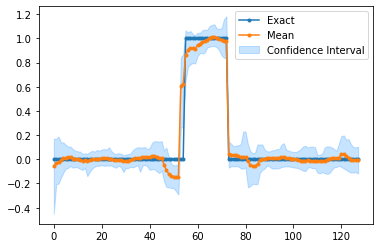

In [27]:

# Cauchy prior
scale = 2/n
tp.prior = cuqi.distribution.Cauchy_diff(np.zeros(n),scale,'neumann')

# Sample
result = tp.sample(Ns)

# plot mean + 95% of samples
result.plot_ci(95,exact=tp.exactSolution)


..\cuqi\sampler.py:190: RuntimeWarning: overflow encountered in exp
  ratio = np.exp(target_eval_star - target_eval_t)  # proposal is symmetric


Burn-in 0 / 1000
Burn-in 500 / 1000
Burn-in 1000 / 1000
Sample 500 / 5000
Sample 1000 / 5000
Sample 1500 / 5000
Sample 2000 / 5000
Sample 2500 / 5000
Sample 3000 / 5000
Sample 3500 / 5000
Sample 4000 / 5000
Sample 4500 / 5000

Average acceptance rate all components: 0.14313593749999998 



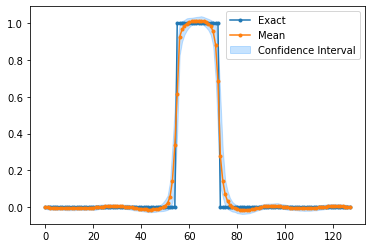

In [28]:

# Set up Laplace prior
loc = np.zeros(dim)
delta = 0.5
scale = delta*1/dim
prior = cuqi.distribution.Laplace_diff(loc,scale,'zero')

# Target and proposal
def target(x): return tp.likelihood.logpdf(tp.data,x)+prior.logpdf(x)
def proposal(x,scale): return np.random.normal(x,scale)

# Parameters for sampler
scale = 0.05*np.ones(dim)
x0 = 0.5*np.ones(dim)

# Define sampler (Component-Wise Metroplis-Hastings)
MCMC = cuqi.sampler.CWMH(target, proposal, scale, x0)

# Burn-in
Nb = int(0.2*Ns)   

# Run sampler (with adaptive parameter selection)
x_s = MCMC.sample_adapt(Ns,Nb)[0]

# Store as cuqi samples
result = cuqi.samples.Samples(x_s)

# plot mean + 95 ci of samples using specific sampler
result.plot_ci(95,exact=tp.exactSolution)


In [ ]:
# Hyperparameters!

# One idea for defining hyperparameters
std = cuqi.distribution.Gamma(1,1e-4)
prior = cuqi.distribution.Gaussian(np.zeros(n),std,corrmat)

IP = cuqi.problem.Type1(data,model,noise,prior)
result = IP.sample(Ns)

